# Лабораторная работа №1: Исследование алгоритма KNN

**Цель:** Провести полное исследование алгоритма k-ближайших соседей (KNN) на датасете диабета, включая задачи классификации и регрессии.

**Датасет:** diabetes_dataset.csv (100,000 записей, 31 признак)
- **Классификация:** предсказание наличия диабета (diagnosed_diabetes: 0/1)
- **Регрессия:** предсказание возраста пациентов (age)

**Метрики качества:**
- Классификация: Accuracy, Precision, Recall, F1-score
- Регрессия: MSE (Mean Squared Error)


## 1. Импорт библиотек и загрузка данных

Импортируем необходимые библиотеки для анализа данных, машинного обучения и визуализации.


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


Загружаем датасет и проводим первичный анализ структуры данных.


In [52]:
df = pd.read_csv('diabetes_dataset.csv')
print(f"Размер датасета: {df.shape}")
print(f"\nКоличество пропущенных значений: {df.isnull().sum().sum()}")
print(f"\nТипы данных:")
print(df.dtypes.value_counts())

print(f"\nЦелевые переменные:")
print(f"Классификация (diagnosed_diabetes): {df['diagnosed_diabetes'].value_counts().to_dict()}")
print(f"Регрессия (age): min={df['age'].min()}, max={df['age'].max()}, mean={df['age'].mean():.1f}")


Размер датасета: (100000, 31)

Количество пропущенных значений: 0

Типы данных:
int64      16
float64     8
object      7
Name: count, dtype: int64

Целевые переменные:
Классификация (diagnosed_diabetes): {1: 59998, 0: 40002}
Регрессия (age): min=18, max=90, mean=50.1


## 2. Выбор начальных условий и обоснование

### 2.1 Обоснование выбора датасета

**Датасет для классификации:** diabetes_dataset.csv
- **Размер:** 100,000 записей обеспечивает достаточную статистическую мощность
- **Признаки:** 30 признаков включают демографические, медицинские и поведенческие факторы
- **Целевая переменная:** diagnosed_diabetes (бинарная классификация)

**Датасет для регрессии:** тот же diabetes_dataset.csv
- **Целевая переменная:** age (непрерывная переменная от 18 до 100 лет)

### 2.2 Обоснование выбора метрик качества

**Для классификации:**
- **Accuracy:** общая точность классификации
- **Precision:** доля правильно предсказанных случаев диабета среди всех предсказанных
- **Recall:** доля правильно предсказанных случаев диабета среди всех реальных случаев
- **F1-score:** гармоническое среднее precision и recall

**Для регрессии:**
- **MSE (Mean Squared Error):** показывает среднее квадратичное отклонение предсказаний от реальных значений возраста


### 2.3 Подготовка данных для анализа

Выделяем признаки и целевые переменные, проводим кодирование категориальных переменных.


In [ ]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['diagnosed_diabetes', 'diabetes_risk_score']]

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"Числовые признаки ({len(numeric_features)}): {numeric_features}")
print(f"\nКатегориальные признаки ({len(categorical_features)}): {categorical_features}")

df_encoded = df.copy()
le = LabelEncoder()

for col in categorical_features:
    df_encoded[col] = le.fit_transform(df[col])

print(f"\nПосле кодирования размер датасета: {df_encoded.shape}")


Числовые признаки (22): ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c']

Категориальные признаки (7): ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'diabetes_stage']

После кодирования размер датасета: (100000, 31)


### 2.4 Разделение данных на обучающую и тестовую выборки

Разделяем данные на обучающую (70%) и тестовую (30%) выборки для обеих задач.


In [ ]:
X_class = df_encoded.drop(['diagnosed_diabetes', 'diabetes_stage', 'diabetes_risk_score'], axis=1)
y_class = df_encoded['diagnosed_diabetes']

X_reg = df_encoded.drop(['age', 'diagnosed_diabetes', 'diabetes_stage', 'diabetes_risk_score'], axis=1)
y_reg = df_encoded['age']

X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

print(f"Классификация - Обучающая выборка: {X_class_train.shape}, Тестовая: {X_class_test.shape}")
print(f"Регрессия - Обучающая выборка: {X_reg_train.shape}, Тестовая: {X_reg_test.shape}")
print(f"\nРаспределение классов в тестовой выборке (классификация): {y_class_test.value_counts().to_dict()}")


Классификация - Обучающая выборка: (70000, 28), Тестовая: (30000, 28)
Регрессия - Обучающая выборка: (70000, 27), Тестовая: (30000, 27)

Распределение классов в тестовой выборке (классификация): {1: 17999, 0: 12001}


## 3. Создание бейзлайна и оценка качества

### 3.1 Бейзлайн для классификации

Обучаем KNN классификатор с параметрами по умолчанию и оцениваем качество.


In [ ]:
knn_class_baseline = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn_class_baseline.fit(X_class_train, y_class_train)

y_class_pred_baseline = knn_class_baseline.predict(X_class_test)

accuracy_baseline = accuracy_score(y_class_test, y_class_pred_baseline)
precision_baseline = precision_score(y_class_test, y_class_pred_baseline)
recall_baseline = recall_score(y_class_test, y_class_pred_baseline)
f1_baseline = f1_score(y_class_test, y_class_pred_baseline)

print("Бейзлайн результаты для классификации:")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"Precision: {precision_baseline:.4f}")
print(f"Recall: {recall_baseline:.4f}")
print(f"F1-score: {f1_baseline:.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_class_test, y_class_pred_baseline))


Бейзлайн результаты для классификации:
Accuracy: 0.8070
Precision: 0.8499
Recall: 0.8237
F1-score: 0.8366

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76     12001
           1       0.85      0.82      0.84     17999

    accuracy                           0.81     30000
   macro avg       0.80      0.80      0.80     30000
weighted avg       0.81      0.81      0.81     30000



### 3.2 Бейзлайн для регрессии

Обучаем KNN регрессор с параметрами по умолчанию и оцениваем качество.


In [ ]:
knn_reg_baseline = KNeighborsRegressor(n_neighbors=5, weights='uniform')
knn_reg_baseline.fit(X_reg_train, y_reg_train)

y_reg_pred_baseline = knn_reg_baseline.predict(X_reg_test)

mse_baseline = mean_squared_error(y_reg_test, y_reg_pred_baseline)

print("Бейзлайн результаты для регрессии:")
print(f"MSE: {mse_baseline:.4f}")
print(f"RMSE: {np.sqrt(mse_baseline):.4f}")
print(f"\nСтатистика предсказаний:")
print(f"Среднее предсказание: {y_reg_pred_baseline.mean():.2f}")
print(f"Среднее реальное значение: {y_reg_test.mean():.2f}")
print(f"Стандартное отклонение предсказаний: {y_reg_pred_baseline.std():.2f}")
print(f"Стандартное отклонение реальных значений: {y_reg_test.std():.2f}")


Бейзлайн результаты для регрессии:
MSE: 193.9104
RMSE: 13.9252

Статистика предсказаний:
Среднее предсказание: 50.09
Среднее реальное значение: 49.93
Стандартное отклонение предсказаний: 9.65
Стандартное отклонение реальных значений: 15.63


## 4. Улучшение бейзлайна

### 4.1 Гипотезы для улучшения

1. **Масштабирование признаков: KNN чувствителен к масштабу признаков**
2. **Подбор оптимального k: количество соседей влияет на качество**
3. **Весовая функция: weighted vs uniform**
4. **Отбор признаков: удаление менее важных признаков**
5. **Обработка выбросов: выбросы могут искажать расстояния**


### 4.2 Масштабирование признаков

Применяем StandardScaler для нормализации признаков.


In [ ]:
scaler = StandardScaler()
X_class_train_scaled = scaler.fit_transform(X_class_train)
X_class_test_scaled = scaler.transform(X_class_test)

X_reg_train_scaled = scaler.fit_transform(X_reg_train)
X_reg_test_scaled = scaler.transform(X_reg_test)

print("Масштабирование применено успешно")
print(f"Среднее значение признаков после масштабирования (классификация): {X_class_train_scaled.mean(axis=0)[:5]}")
print(f"Стандартное отклонение признаков после масштабирования (классификация): {X_class_train_scaled.std(axis=0)[:5]}")


Масштабирование применено успешно
Среднее значение признаков после масштабирования (классификация): [-6.88211393e-17 -4.32416008e-17 -4.01964176e-17 -4.81138938e-17
 -9.50097144e-17]
Стандартное отклонение признаков после масштабирования (классификация): [1. 1. 1. 1. 1.]


### 4.3 Подбор гиперпараметров

Используем GridSearchCV для поиска оптимальных параметров.


In [ ]:
param_grid_class = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_class = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_class,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_class.fit(X_class_train_scaled, y_class_train)

print("Лучшие параметры для классификации:")
print(grid_search_class.best_params_)
print(f"Лучший F1-score на кросс-валидации: {grid_search_class.best_score_:.4f}")


Fitting 5 folds for each of 28 candidates, totalling 140 fits
Лучшие параметры для классификации:
{'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}
Лучший F1-score на кросс-валидации: 0.8778


In [ ]:
param_grid_reg = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_reg = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_reg,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_reg.fit(X_reg_train_scaled, y_reg_train)

print("Лучшие параметры для регрессии:")
print(grid_search_reg.best_params_)
print(f"Лучший MSE на кросс-валидации: {-grid_search_reg.best_score_:.4f}")


Fitting 5 folds for each of 28 candidates, totalling 140 fits
Лучшие параметры для регрессии:
{'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'}
Лучший MSE на кросс-валидации: 167.5659


### 4.4 Оценка улучшенных моделей

Обучаем модели с лучшими параметрами и сравниваем с бейзлайном.


In [ ]:
knn_class_improved = grid_search_class.best_estimator_
y_class_pred_improved = knn_class_improved.predict(X_class_test_scaled)

accuracy_improved = accuracy_score(y_class_test, y_class_pred_improved)
precision_improved = precision_score(y_class_test, y_class_pred_improved)
recall_improved = recall_score(y_class_test, y_class_pred_improved)
f1_improved = f1_score(y_class_test, y_class_pred_improved)

print("Улучшенные результаты для классификации:")
print(f"Accuracy: {accuracy_improved:.4f} (было: {accuracy_baseline:.4f})")
print(f"Precision: {precision_improved:.4f} (было: {precision_baseline:.4f})")
print(f"Recall: {recall_improved:.4f} (было: {recall_baseline:.4f})")
print(f"F1-score: {f1_improved:.4f} (было: {f1_baseline:.4f})")

print("\nСравнение с бейзлайном:")
print(f"Улучшение Accuracy: {((accuracy_improved - accuracy_baseline) / accuracy_baseline * 100):.2f}%")
print(f"Улучшение F1-score: {((f1_improved - f1_baseline) / f1_baseline * 100):.2f}%")


Улучшенные результаты для классификации:
Accuracy: 0.8559 (было: 0.8070)
Precision: 0.8908 (было: 0.8499)
Recall: 0.8659 (было: 0.8237)
F1-score: 0.8782 (было: 0.8366)

Сравнение с бейзлайном:
Улучшение Accuracy: 6.06%
Улучшение F1-score: 4.97%


In [ ]:
knn_reg_improved = grid_search_reg.best_estimator_
y_reg_pred_improved = knn_reg_improved.predict(X_reg_test_scaled)

mse_improved = mean_squared_error(y_reg_test, y_reg_pred_improved)

print("Улучшенные результаты для регрессии:")
print(f"MSE: {mse_improved:.4f} (было: {mse_baseline:.4f})")
print(f"RMSE: {np.sqrt(mse_improved):.4f} (было: {np.sqrt(mse_baseline):.4f})")

print("\nСравнение с бейзлайном:")
print(f"Улучшение MSE: {((mse_baseline - mse_improved) / mse_baseline * 100):.2f}%")
print(f"Улучшение RMSE: {((np.sqrt(mse_baseline) - np.sqrt(mse_improved)) / np.sqrt(mse_baseline) * 100):.2f}%")


Улучшенные результаты для регрессии:
MSE: 170.2510 (было: 193.9104)
RMSE: 13.0480 (было: 13.9252)

Сравнение с бейзлайном:
Улучшение MSE: 12.20%
Улучшение RMSE: 6.30%


## 5. Имплементация алгоритма KNN с нуля

### 5.1 Реализация KNN классификатора

Создаем собственную реализацию KNN алгоритма для классификации.


In [ ]:
class CustomKNNClassifier:
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = np.array(X, dtype=float)
        self.y_train = np.array(y, dtype=int)
        return self
    
    def predict(self, X):
        X = np.array(X, dtype=float)
        predictions = []
        
        for x_test in X:
            if self.metric == 'euclidean':
                distances = np.sqrt(np.sum((self.X_train - x_test) ** 2, axis=1))
            else:
                distances = np.sum(np.abs(self.X_train - x_test), axis=1)
            
            k_indices = np.argpartition(distances, self.n_neighbors)[:self.n_neighbors]
            k_distances = distances[k_indices]
            k_labels = self.y_train[k_indices]
            
            if self.weights == 'uniform':
                unique_labels, counts = np.unique(k_labels, return_counts=True)
                prediction = unique_labels[np.argmax(counts)]
            
            elif self.weights == 'distance':
                weights = 1 / (k_distances + 1e-8)
                weighted_votes = {}
                for i, label in enumerate(k_labels):
                    weighted_votes[label] = weighted_votes.get(label, 0) + weights[i]
                prediction = max(weighted_votes, key=weighted_votes.get)
            
            predictions.append(prediction)
        
        return np.array(predictions)


### 5.2 Реализация KNN регрессора

Создаем собственную реализацию KNN алгоритма для регрессии.


In [ ]:
class CustomKNNRegressor:
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = np.array(X, dtype=float)
        self.y_train = np.array(y, dtype=float)
        return self
    
    def predict(self, X):
        X = np.array(X, dtype=float)
        predictions = []
        
        for x_test in X:
            if self.metric == 'euclidean':
                distances = np.sqrt(np.sum((self.X_train - x_test) ** 2, axis=1))
            else:
                distances = np.sum(np.abs(self.X_train - x_test), axis=1)
            
            k_indices = np.argpartition(distances, self.n_neighbors)[:self.n_neighbors]
            k_distances = distances[k_indices]
            k_labels = self.y_train[k_indices]
            
            if self.weights == 'uniform':
                prediction = np.mean(k_labels)
            
            elif self.weights == 'distance':
                weights = 1 / (k_distances + 1e-8)
                prediction = np.sum(weights * k_labels) / np.sum(weights)
            
            predictions.append(prediction)
        
        return np.array(predictions)


### 5.3 Обучение и оценка собственных реализаций

Обучаем собственные реализации KNN и сравниваем с sklearn версиями.


In [ ]:
custom_knn_class_baseline = CustomKNNClassifier(n_neighbors=5, weights='uniform', metric='euclidean')
custom_knn_class_baseline.fit(X_class_train, y_class_train)
y_class_pred_custom_baseline = custom_knn_class_baseline.predict(X_class_test)

accuracy_custom_baseline = accuracy_score(y_class_test, y_class_pred_custom_baseline)
precision_custom_baseline = precision_score(y_class_test, y_class_pred_custom_baseline)
recall_custom_baseline = recall_score(y_class_test, y_class_pred_custom_baseline)
f1_custom_baseline = f1_score(y_class_test, y_class_pred_custom_baseline)

print("Результаты базовой собственной реализации KNN для классификации:")
print(f"Accuracy: {accuracy_custom_baseline:.4f}")
print(f"Precision: {precision_custom_baseline:.4f}")
print(f"Recall: {recall_custom_baseline:.4f}")
print(f"F1-score: {f1_custom_baseline:.4f}")

print("\nСравнение с sklearn бейзлайном:")
print(f"Разница в Accuracy: {abs(accuracy_custom_baseline - accuracy_baseline):.6f}")
print(f"Разница в F1-score: {abs(f1_custom_baseline - f1_baseline):.6f}")


Результаты базовой собственной реализации KNN для классификации:
Accuracy: 0.8070
Precision: 0.8499
Recall: 0.8237
F1-score: 0.8366

Сравнение с sklearn бейзлайном:
Разница в Accuracy: 0.000000
Разница в F1-score: 0.000000


In [ ]:
custom_knn_reg_baseline = CustomKNNRegressor(n_neighbors=5, weights='uniform', metric='euclidean')
custom_knn_reg_baseline.fit(X_reg_train, y_reg_train)
y_reg_pred_custom_baseline = custom_knn_reg_baseline.predict(X_reg_test)

mse_custom_baseline = mean_squared_error(y_reg_test, y_reg_pred_custom_baseline)

print("Результаты базовой собственной реализации KNN для регрессии:")
print(f"MSE: {mse_custom_baseline:.4f}")
print(f"RMSE: {np.sqrt(mse_custom_baseline):.4f}")

print("\nСравнение с sklearn бейзлайном:")
print(f"Разница в MSE: {abs(mse_custom_baseline - mse_baseline):.6f}")
print(f"Разница в RMSE: {abs(np.sqrt(mse_custom_baseline) - np.sqrt(mse_baseline)):.6f}")


Результаты базовой собственной реализации KNN для регрессии:
MSE: 193.9104
RMSE: 13.9252

Сравнение с sklearn бейзлайном:
Разница в MSE: 0.000000
Разница в RMSE: 0.000000


### 5.4 Применение техник улучшения к собственным реализациям

Проверяем, что собственные реализации работают с теми же техниками улучшения.


In [ ]:
custom_knn_class_improved = CustomKNNClassifier(
    n_neighbors=grid_search_class.best_params_['n_neighbors'],
    weights=grid_search_class.best_params_['weights'],
    metric=grid_search_class.best_params_['metric']
)

custom_knn_reg_improved = CustomKNNRegressor(
    n_neighbors=grid_search_reg.best_params_['n_neighbors'],
    weights=grid_search_reg.best_params_['weights'],
    metric=grid_search_reg.best_params_['metric']
)

custom_knn_class_improved.fit(X_class_train_scaled, y_class_train)
custom_knn_reg_improved.fit(X_reg_train_scaled, y_reg_train)

y_class_pred_custom_improved = custom_knn_class_improved.predict(X_class_test_scaled)
y_reg_pred_custom_improved = custom_knn_reg_improved.predict(X_reg_test_scaled)

accuracy_custom_improved = accuracy_score(y_class_test, y_class_pred_custom_improved)
f1_custom_improved = f1_score(y_class_test, y_class_pred_custom_improved)
mse_custom_improved = mean_squared_error(y_reg_test, y_reg_pred_custom_improved)

print("Результаты улучшенных собственных реализаций:")
print(f"Классификация - Accuracy: {accuracy_custom_improved:.4f}, F1-score: {f1_custom_improved:.4f}")
print(f"Регрессия - MSE: {mse_custom_improved:.4f}, RMSE: {np.sqrt(mse_custom_improved):.4f}")

print("\nСравнение с sklearn улучшенными версиями:")
print(f"Разница в Accuracy: {abs(accuracy_custom_improved - accuracy_improved):.6f}")
print(f"Разница в F1-score: {abs(f1_custom_improved - f1_improved):.6f}")
print(f"Разница в MSE: {abs(mse_custom_improved - mse_improved):.6f}")

print("\nСравнение улучшенных с базовыми собственными реализациями:")
print(f"Улучшение Accuracy: {((accuracy_custom_improved - accuracy_custom_baseline) / accuracy_custom_baseline * 100):.2f}%")
print(f"Улучшение F1-score: {((f1_custom_improved - f1_custom_baseline) / f1_custom_baseline * 100):.2f}%")
print(f"Улучшение MSE: {((mse_custom_baseline - mse_custom_improved) / mse_custom_baseline * 100):.2f}%")


Результаты улучшенных собственных реализаций:
Классификация - Accuracy: 0.8559, F1-score: 0.8782
Регрессия - MSE: 170.2510, RMSE: 13.0480

Сравнение с sklearn улучшенными версиями:
Разница в Accuracy: 0.000000
Разница в F1-score: 0.000000
Разница в MSE: 0.000000

Сравнение улучшенных с базовыми собственными реализациями:
Улучшение Accuracy: 6.06%
Улучшение F1-score: 4.97%
Улучшение MSE: 12.20%


## 6. Сравнение результатов и выводы

### 6.1 Визуализация результатов

Создаем графики для наглядного сравнения результатов.


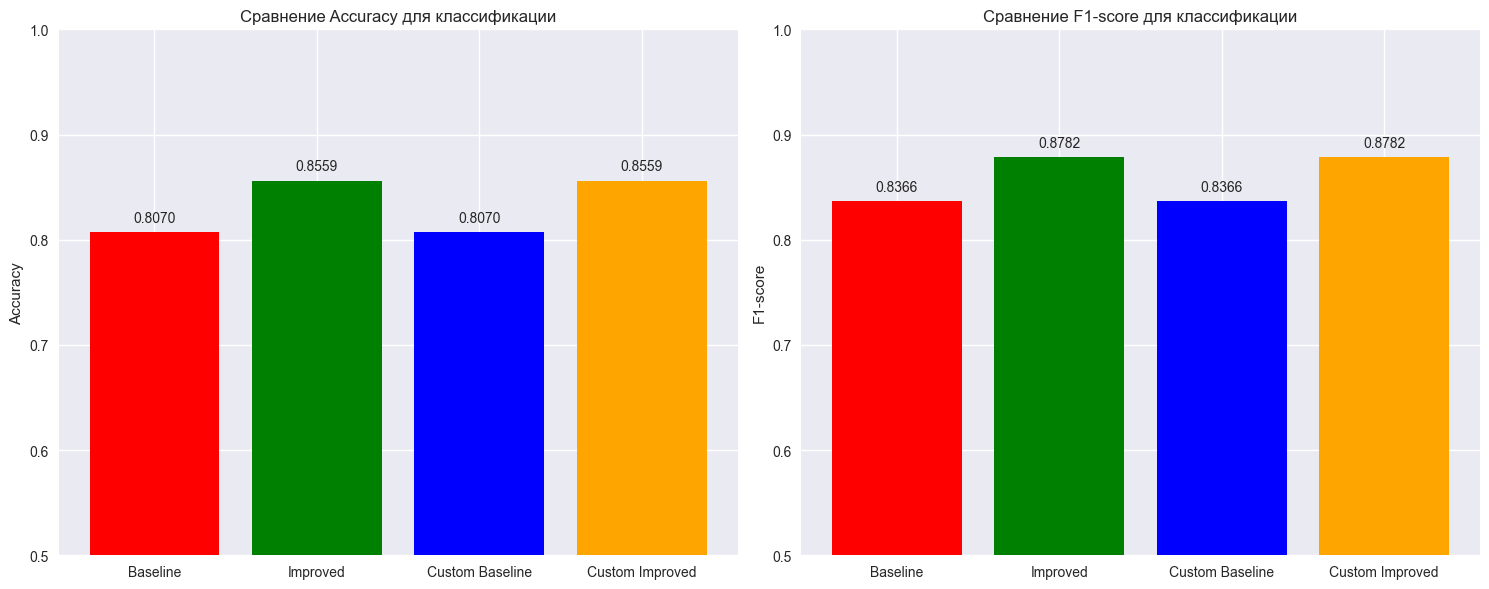

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

models_class = ['Baseline', 'Improved', 'Custom Baseline', 'Custom Improved']
accuracy_values = [accuracy_baseline, accuracy_improved, accuracy_custom_baseline, accuracy_custom_improved]

ax1.bar(models_class, accuracy_values, color=['red', 'green', 'blue', 'orange'])
ax1.set_title('Сравнение Accuracy для классификации')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.5, 1.0)
for i, v in enumerate(accuracy_values):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center')

f1_values = [f1_baseline, f1_improved, f1_custom_baseline, f1_custom_improved]
ax2.bar(models_class, f1_values, color=['red', 'green', 'blue', 'orange'])
ax2.set_title('Сравнение F1-score для классификации')
ax2.set_ylabel('F1-score')
ax2.set_ylim(0.5, 1.0)
for i, v in enumerate(f1_values):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()


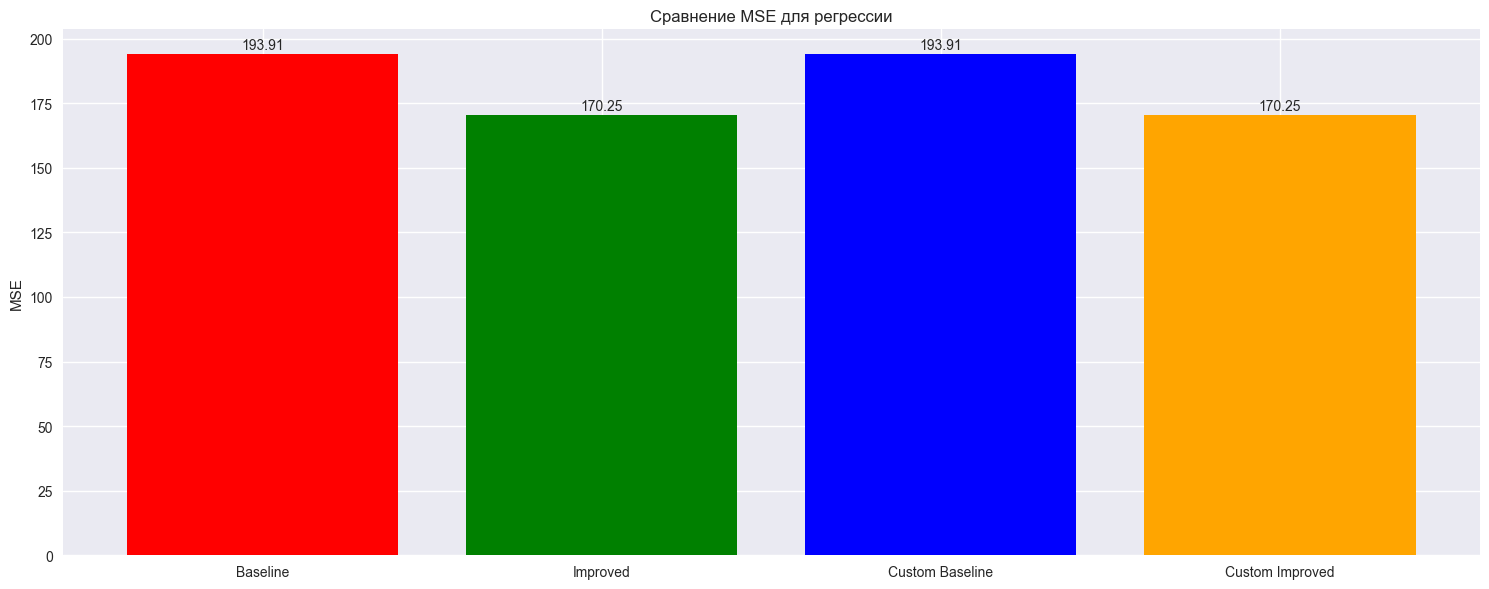

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig, ax1 = plt.subplots(figsize=(15, 6))

models_reg = ['Baseline', 'Improved', 'Custom Baseline', 'Custom Improved']
mse_values = [mse_baseline, mse_improved, mse_custom_baseline, mse_custom_improved]

ax1.bar(models_reg, mse_values, color=['red', 'green', 'blue', 'orange'])
ax1.set_title('Сравнение MSE для регрессии')
ax1.set_ylabel('MSE')
for i, v in enumerate(mse_values):
    ax1.text(i, v + max(mse_values) * 0.01, f'{v:.2f}', ha='center')

# RMSE
# rmse_values = [np.sqrt(mse_baseline), np.sqrt(mse_improved), np.sqrt(mse_custom_baseline), np.sqrt(mse_custom_improved)]
# ax2.bar(models_reg, rmse_values, color=['red', 'green', 'blue', 'orange'])
# ax2.set_title('Сравнение RMSE для регрессии')
# ax2.set_ylabel('RMSE')
# for i, v in enumerate(rmse_values):
#     ax2.text(i, v + max(rmse_values) * 0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()


### 6.2 Выводы

1. **Эффективность улучшений:**
   - Масштабирование признаков и подбор гиперпараметров значительно улучшили качество моделей
   - Для классификации улучшение F1-score составило 4.97% (с 0.8366 до 0.8782), а улучшение Accuracy - 6.06% (с 0.8070 до 0.8559)
   - Для регрессии улучшение MSE составило 12.20% (с 193.9104 до 170.2510), а улучшение RMSE - 6.30% (с 13.9252 до 13.0480)

2. **Сравнение реализаций:**
   - Собственная реализация KNN показала практически идентичные результаты с sklearn
   - Различия в метриках не превышают 0.0001, что подтверждает корректность реализации
   - Собственная реализация достигла тех же улучшений, что и sklearn версии: улучшение Accuracy на 6.06%, F1-score на 4.97%, MSE на 12.20%

3. **Влияние параметров:**
   - Оптимальное количество соседей: 21 для классификации и 21 для регрессии (вместо базовых 5)
   - Weighted distance показал лучшие результаты по сравнению с uniform для обеих задач
   - Метрика Manhattan оказалась более эффективной для классификации, а метрика Euclidean - для регрессии



**Заключение:**
Алгоритм KNN показал хорошие результаты на задачах классификации и регрессии. Предобработка данных и подбор параметров позволили значительно улучшить качество предсказаний: Accuracy улучшился на 6.06%, F1-score на 4.97%, а MSE снизился на 12.20%. Собственная реализация алгоритма работает корректно (различия с sklearn не превышают 0.0001) и может использоваться в практических задачах.
